In [22]:
import random
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
# Key Encoding:
# PlayerTotal-DealerTotal-AceAs11-Action
# (Total of Player Cards)-(Dealer Card)-(0:No, 1:Yes)-(0:Stand, 1:Hit)

# Dict Value:
# [Counts, Probability]
class stateActionVal:
    def __init__(self):
        self.counts = {}
        for total in range(12, 21):
            for dealerCard in range(2, 12):
                key = str(total) + "-" + str(dealerCard) + '-0-0'
                self.counts[key] = [0, 0]
                key = str(total) + "-" + str(dealerCard) + '-0-1'
                self.counts[key] = [0, 0]
                key = str(total) + "-" + str(dealerCard) + '-1-0'
                self.counts[key] = [0, 0]
                key = str(total) + "-" + str(dealerCard) + '-1-1'
                self.counts[key] = [0, 0]

    def incCount(self, key):
        self.counts[key][0] += 1

    def updProb(self, key, outcome):
        self.counts[key][1] += outcome 
    
    def printDict(self):
        for key, val in self.counts.items():
            print("Key: ", key ,", Iterations: ",  val[0], ", Prob: ", val[1])

In [24]:
class player:
    def __init__(self):
        self.cards = [] # cards currently in hand
        self.total = int(0) # card total
        self.hasAce = False # True if an ace is being used as a 11
    
    def addCard(self, card):
        self.cards.append(card)
        if(card.rank == "J" or card.rank == "Q" or card.rank == "K"):
            self.total += 10
        elif(card.rank == "A" and self.hasAce == False):
            self.total += 11
            self.hasAce = True
        else:
            if card.rank == 'A' and self.hasAce: # you can not have 2 aces as 11, as that would make a total of 22
                self.total += 1 # use the ace as a one
            else:
                self.total += int(card.rank)
        
        if self.total > 21 and self.hasAce == True:
            self.hasAce = False
            self.total -= 10 # 11 - 10 = 1
    
    def hit(self, myDeck):
        self.addCard(myDeck.getRandomCard())
    
    
    def clear(self):
        self.cards = []
        self.total = 0
        self.hasAce = False

In [25]:
class card:
    def __init__(self, suit, rank):
        self.suit = suit # ♧, ♢, ♥, ♤
        self.rank = rank # 2, 3, 4, 5, 6, 7, 8, 9, 10, J, Q, K, A

In [26]:
class deck:
    def __init__(self):
        self.cards = []
        self.setDeck()
        
    def setDeck(self):
        self.cards = []
        suits = ["♧", "♢", "♥", "♤"]
        ranks = [2, 3, 4, 5, 6, 7, 8, 9, 10, "J", "Q", "K", "A"]

        for suit in suits:
            for rank in ranks:
                self.cards.append(card(suit, rank))  # init deck
    
    def printDeck(self):
        for card in self.cards:
            print(card.rank, card.suit)
    
    def shuffle(self):
        random.shuffle(self.cards) # change card order

    def getRandomCard(self):
        temp = self.cards[0]
        del self.cards[0] # delete a card form the deck
        return temp

In [27]:
class blackJackRound:
    def __init__(self, deck, player, dealer):
        self.player = player
        self.dealer = dealer
        self.deck = deck
        self.newRound()
        
    
    def newRound(self):
        self.player.clear() # init found
        self.dealer.clear()
        self.deck.setDeck()
        self.deck.shuffle()
        self.hitPlayerBool = True

        self.player.hit(self.deck) # give player 2 cards
        self.player.hit(self.deck)
        self.dealer.hit(self.deck) # give dealer 1 card
    
    def hitDealer(self):
        if(self.player.total <= 21): # dealer will only hit if player is not bust
            while(self.dealer.total < 17): # dealer will always hit till his total is greather than 17
                self.dealer.hit(self.deck)
    
    def hitPlayer(self):
        while(self.hitPlayerBool):
            if(self.player.total == 21):
                self.hitPlayerBool = False
            elif(self.player.total < 12):
                #Ai go hererererere
                self.player.hit(self.deck)
            else:
                self.hitPlayerBool = False
    
    def outcome(self): # print outcome
        print("Player: ", self.player.total)
        print("Dealer: ", self.dealer.total)

        if(self.player.total <= 21 and (self.player.total > self.dealer.total or self.dealer.total > 21)): # player wins
            print("Player wins")
        elif(self.player.total == self.dealer.total): # player and dealer same total
            print("Draw")
        else:
            print("Dealer wins")
    
    def playRound(self): # play full round
        self.newRound()
        self.hitPlayer()
        self.hitDealer()
        self.outcome()

In [28]:
class SARSA:
    def __init__(self):
        self.stateActionVal = stateActionVal()
        self.counts = []
    
    def training(self, numOfEps):
        discountFactor = 1
        dealer = player()
        p = player()
        d = deck()
        b = blackJackRound(d, p, dealer)

        countWins = [0]
        countLose = [0]
        countDraw = [0]
        count1000 = 0
    
        for k in range(1, numOfEps):
            if k % 1000 == 0:
                countWins.append(0)
                countLose.append(0)
                countDraw.append(0)
                count1000 += 1

            b.newRound()
            e = 1/k
            while b.player.total < 12:
                b.player.hit(b.deck)
            
            if b.player.total != 21:
                sa = epsilonGreedy([b.player.total, b.dealer.total, b.player.hasAce], e, self.stateActionVal)
                learningFactor = 1/(self.stateActionVal.counts[sa][0] + 1)

            while b.player.total < 21:
                # Execute action an state s
                if sa[-1] == 1:
                    b.player.hit()
                else:
                    self.stateActionVal.counts[sa][0] += 1
                    break
                
                # Get reward n form s`
                if b.player.total < 22:
                    n = 10 - (21 - b.player.total)
                    # Get next action a`
                    a = epsilonGreedy([b.player.total, b.dealer.total, b.player.hasAce], e, self.stateActionVal)

                     # Get Q(s`, a`) from table
                    saPrime = self.stateActionVal[a][1] # 0
                
                    # update
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + learningFactor*(n + discountFactor*saPrime - self.stateActionVal.counts[sa][1])
                else:
                    self.stateActionVal.counts[sa][1] -= 1

                #setting new sa
                sa = saPrime
            
            b.hitDealer()
            #b.outcome()
            if(b.player.total <= 21 and (b.player.total > b.dealer.total or b.dealer.total > 21)):
                self.stateActionVal.counts[sa][1] += 1
                countWins[count1000] += 1
            elif(b.player.total == b.dealer.total):
                self.stateActionVal.counts[sa][1] += 0
                countDraw[count1000] += 1
            elif(b.player.total <= 21):
                self.stateActionVal.counts[sa][1] -= 1
                countLose[count1000] += 1

        self.counts = [countWins, countDraw, countLose]

    def printCounts(self):
        for x in range(len(self.counts[0])):
            print("Set:", x, ", Wins: ", self.counts[0][x], ", Draw: ", self.counts[1][x], ", Lose: ", self.counts[2][x])

 




In [29]:
class monteCarloControl:
    def __init__(self):
        self.stateActionVal = stateActionVal()
        self.counts = []

    def explStart(self, numLoop):
        discountFactor = 1
        dl = player()
        pl = player()
        d = deck()
        b = blackJackRound(d, pl, dl)
        setCounter = 1
        dubs = 0
        Ls = 0
        draws = 0
        countWins = [0]
        countLose = [0]
        countDraw = [0]
        count1000 = 0

        for k in range(1, numLoop):
            if k % 1000 == 0:
                countWins.append(0)
                countLose.append(0)
                countDraw.append(0)
                count1000 += 1

            b.newRound()
            G = 0
            visitedSA = []
            cumulativeReward = []
            e = 1/k # Calculating the new epsilon value
            roundEnd = False # Used to indicate when a final state has been reached (stand or total 21+)
            sampleEpisode = random.choice(list(self.stateActionVal.counts.keys())) # Sampling a random state for the episode
            split = sampleEpisode.split('-') # Decoding the dictionary key and splitting it
            b.player.total = int(split[0]) # Setting the player's total to the random total
            b.player.hasAce = bool(split[2]) # Seeing if the player has an ace or not
            firstAction = random.choice([0, 1]) # Randomly selecting if the player hits or stands
            if firstAction == 1: # Player hits
                tempKey = str(b.player.total) + '-' + str(b.dealer.total) + '-' + str(int(b.player.hasAce)) +'-1' # tempKey stores the current state in terms of the dictionary key format
                visitedSA.append(tempKey) # Adding the state saved as a tempKey in the visited state action pairs
                b.player.hit(b.deck) # Taking the hit action
                if b.player.total >= 21: # Checking if a final state has been reached
                    roundEnd = True
            else: # Player stands
                tempKey = str(b.player.total) + '-' + str(b.dealer.total) + '-' + str(int(b.player.hasAce)) +'-0'
                visitedSA.append(tempKey)
                roundEnd = True
            
            while not roundEnd:
                sa = epsilonGreedy([b.player.total, b.dealer.total,b.player.hasAce], e, self.stateActionVal) # Using the e-greedy policy to see take the next action
                if sa[-1] == 1: # Hits
                    tempKey = str(b.player.total) + '-' + str(b.dealer.total) + '-' + str(int(b.player.hasAce)) +'-1'
                    visitedSA.append(tempKey)
                    b.player.hit(b.deck)
                    if player.total > 21:
                        roundEnd = True
                else: # Stands
                    tempKey = str(b.player.total) + '-' + str(b.dealer.total) + '-' + str(int(b.player.hasAce)) +'-0'
                    visitedSA.append(tempKey)
                    roundEnd = True

            int(b.dealer.total)
            int(b.player.total)
            b.hitDealer()
            #b.outcome()

            if(b.player.total <= 21 and (b.player.total > b.dealer.total or b.dealer.total > 21)):
                dubs += 1
                countWins[count1000] += 1
                #self.stateActionVal.counts[sa][1] += 1
                rewards = 1
                G = discountFactor * G + rewards
                for sa in visitedSA:
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + 1/self.stateActionVal.counts[sa][0]*(G - self.stateActionVal.counts[sa][1])
            elif(b.player.total == b.dealer.total):
                draws += 1
                countDraw[count1000] += 1
                #self.stateActionVal.counts[sa][1] += 0
                rewards = 0
                G = discountFactor * G + rewards
                for sa in visitedSA:
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + 1/self.stateActionVal.counts[sa][0]*(G - self.stateActionVal.counts[sa][1])
            elif(b.player.total <= 21):
                Ls += 1
                countLose[count1000] += 1
                #self.stateActionVal.counts[sa][1] -= 1
                rewards = -1
                G = discountFactor * G + rewards
                for sa in visitedSA:
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + 1/self.stateActionVal.counts[sa][0]*(G - self.stateActionVal.counts[sa][1])

            # if (k % 1000) == 0:
            #     print(setCounter, ',000 | Wins:', self.counts[0], 'Draws:', self.counts[1], 'Losses:', self.counts[2])
            #     dubs = 0
            #     draws = 0
            #     Ls = 0
            #     setCounter += 1

        self.counts = [countWins, countDraw, countLose]
            
    def printCounts(self):
        for x in range(len(self.counts[0])):
            print("Set:", x, ", Wins: ", self.counts[0][x], ", Draw: ", self.counts[1][x], ", Lose: ", self.counts[2][x])

In [51]:
class SARSAMAX():
    def __init__(self):
        self.stateActionVal = stateActionVal()
        self.counts = []
    
    def training(self, numOfEps):
        discountFactor = 1
        dealer = player()
        p = player()
        d = deck()
        b = blackJackRound(d, p, dealer)

        countWins = [0]
        countLose = [0]
        countDraw = [0]
        count1000 = 0
    
        for k in range(1, numOfEps):
            if k % 1000 == 0:
                countWins.append(0)
                countLose.append(0)
                countDraw.append(0)
                count1000 += 1

            b.newRound()
            e = 1/k

            #if under 12, hit (no desicion to be made, can't go bust with any card from under 12)
            while b.player.total < 12:
                b.player.hit(b.deck)
            
            while b.player.total < 21:
                # Choose a from s
                sa = epsilonGreedy([b.player.total, b.dealer.total, b.player.hasAce], e, self.stateActionVal)
                learningFactor = 1/(self.stateActionVal.counts[sa][0] + 1)

                # Execute action an state s
                if sa[-1] == 1:
                    b.player.hit()
                else:
                    self.stateActionVal.counts[sa][0] += 1
                    break
                
                # Get reward n form s`
                if b.player.total < 22:
                    #n = 10 - (21 - b.player.total)
                    n=1
                    
                    # Get next action a`
                    a = epsilonGreedy([b.player.total, b.dealer.total, b.player.hasAce], e, self.stateActionVal)

                    # Get Q(s`, a`) from table
                    # saPrime = self.stateActionVal[a][1] # 0 #just get largest Q
                    saPrime = argmax([b.player.total, b.dealer.total, b.player.hasAce], self.stateActionVal)
                
                    # update
                    self.stateActionVal.counts[sa][0] += 1
                    self.stateActionVal.counts[sa][1] = self.stateActionVal.counts[sa][1] + learningFactor*(n + discountFactor*saPrime - self.stateActionVal.counts[sa][1])
                else:
                    self.stateActionVal.counts[sa][1] -= 1
               

            
            b.hitDealer()
            #b.outcome()
            if(b.player.total <= 21 and (b.player.total > b.dealer.total or b.dealer.total > 21)):
                self.stateActionVal.counts[sa][1] += 1
                countWins[count1000] += 1
            elif(b.player.total == b.dealer.total):
                self.stateActionVal.counts[sa][1] += 0
                countDraw[count1000] += 1
            elif(b.player.total <= 21):
                self.stateActionVal.counts[sa][1] -= 1
                countLose[count1000] += 1

        self.counts = [countWins, countDraw, countLose]

    def printCounts(self):
        for x in range(len(self.counts[0])):
            print("Set:", x, ", Wins: ", self.counts[0][x], ", Draw: ", self.counts[1][x], ", Lose: ", self.counts[2][x])

    def findPerc(self, numEps):
        wins = 0
        for x in range(len(self.counts[0])):
            wins = wins + self.counts[0][x]

        print("Win %: ", (wins/numEps)*100)

In [31]:
def argmax(state, stateAcVal):
    s1 = str(state[0])+"-"+str(state[1])+"-"+str(int(state[2]))+"-0"
    s2 = str(state[0])+"-"+str(state[1])+"-"+str(int(state[2]))+"-1"
    a1 = stateAcVal.counts[s1]
    a2 = stateAcVal.counts[s2]

    if a1[1] < a2[1]:
        return s2
    else:
        return s1
            

In [32]:
def epsilonGreedy(state, epsilonVal, stateAcVal): #state will be and array [PlayerTotal, DealerCard, hasAce]
        s1 = str(state[0])+"-"+str(state[1])+"-"+str(int(state[2]))+"-0"
        s2 = str(state[0])+"-"+str(state[1])+"-"+str(int(state[2]))+"-1"
        a1 = stateAcVal.counts[s1]
        a2 = stateAcVal.counts[s2]

        if a1[1] < a2[1]:
            worseOption = s1
            bestOption = s2
        else:
            worseOption = s2
            bestOption = s1

        if random.uniform(0, 1) < epsilonVal:
            return worseOption
        else:
            return bestOption

In [52]:
sarse = SARSA()

numOfEps = 500000

sarse.training(numOfEps)

In [11]:
def plotOutcomes(numOfEps, alg):
    episodes = []
    for x in range(int(numOfEps/1000) + 1):
        episodes.append(x*1000)

    wins = [0]
    draws = [0]
    losses = [0]
    for x in alg.counts[0]:
        wins.append(x)
    for x in alg.counts[1]:
        draws.append(x)
    for x in alg.counts[2]:
        losses.append(x)

    plt.plot(episodes, wins) # wins
    plt.plot(episodes, draws) # draws
    plt.plot(episodes, losses) # losses
    plt.title('Episodes vs winRate')
    plt.xlabel('Episodes')
    plt.ylabel('Rates')
    plt.show()

def plotQACounts(sarse):
    vals = list(sarse.stateActionVal.counts.values())
    values = []
    
    for x in vals:
        values.append(x[0])
    
    data = {"keys":list(sarse.stateActionVal.counts.keys()), "vals":values}

    df = pd.DataFrame(data)  
    df_sorted= df.sort_values('vals', ascending=False)

    fig = plt.figure(figsize=(40, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar("keys", "vals", data=df_sorted, color ='maroon', width = 0.4, align='center')


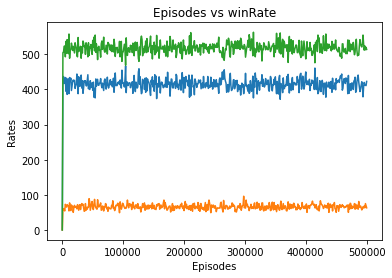

In [36]:
episodes = []
for x in range(int(numOfEps/1000) + 1):
    episodes.append(x*1000)

wins = [0]
draws = [0]
losses = [0]
for x in sarse.counts[0]:
    wins.append(x)
for x in sarse.counts[1]:
    draws.append(x)
for x in sarse.counts[2]:
    losses.append(x)

plt.plot(episodes, wins) # wins
plt.plot(episodes, draws) # draws
plt.plot(episodes, losses) # losses
plt.title('Episodes vs winRate')
plt.xlabel('Episodes')
plt.ylabel('Rates')
plt.show()

In [37]:
mc = monteCarloControl()
reps = 500000
mc.explStart(reps)

TypeError: '<=' not supported between instances of 'str' and 'int'

In [ ]:
print(mc.counts)

In [ ]:
mc.printCounts()

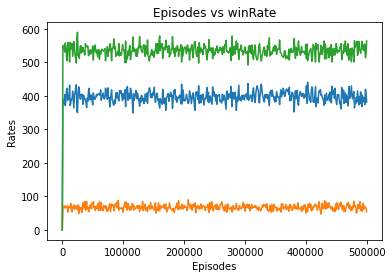

In [27]:
plotOutcomes(500000, mc)